# Phase 4: Check with real events

See if the regimes match actual market events

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("loaded")

loaded


## Load data

In [2]:
# get regime labels
df_regimes = pd.read_csv('../data/processed/regime_labels.csv')
df_regimes['date'] = pd.to_datetime(df_regimes['date'])

# get market data  
df_market = pd.read_csv('../data/processed/full_market_matrix.csv')
df_market['Date'] = pd.to_datetime(df_market['Date'])

# merge
df = df_market.merge(df_regimes, left_on='Date', right_on='date', how='left')

print(f"Data: {df.shape}")
print(f"Dates: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nRegimes:")
print(df['cluster'].value_counts())

Data: (2926, 24)
Dates: 2018-01-01 00:00:00 to 2026-01-04 00:00:00

Regimes:
cluster
0.0    1501
1.0    1394
Name: count, dtype: int64


## List major events to check

In [3]:
# major crypto events we know about
events = [
    {'name': 'COVID-19 Crash', 'date': '2020-03-12', 'should_be': 'fear'},
    {'name': '2021 Bull Peak', 'date': '2021-04-14', 'should_be': 'greed'},
    {'name': 'May 2021 Crash', 'date': '2021-05-19', 'should_be': 'fear'},
    {'name': 'November 2021 Peak', 'date': '2021-11-10', 'should_be': 'greed'},
    {'name': 'Terra/Luna Collapse', 'date': '2022-05-09', 'should_be': 'fear'},
    {'name': 'FTX Collapse', 'date': '2022-11-08', 'should_be': 'fear'},
    {'name': 'ETF Approval Rally', 'date': '2024-01-11', 'should_be': 'greed'},
    {'name': '2024 Halving Rally', 'date': '2024-04-20', 'should_be': 'greed'}
]

df_events = pd.DataFrame(events)
df_events['date'] = pd.to_datetime(df_events['date'])

print(f"{len(df_events)} events to check:")
for _, e in df_events.iterrows():
    print(f"  {e['date'].strftime('%Y-%m-%d')}: {e['name']}")

8 events to check:
  2020-03-12: COVID-19 Crash
  2021-04-14: 2021 Bull Peak
  2021-05-19: May 2021 Crash
  2021-11-10: November 2021 Peak
  2022-05-09: Terra/Luna Collapse
  2022-11-08: FTX Collapse
  2024-01-11: ETF Approval Rally
  2024-04-20: 2024 Halving Rally


## Plot timeline with events

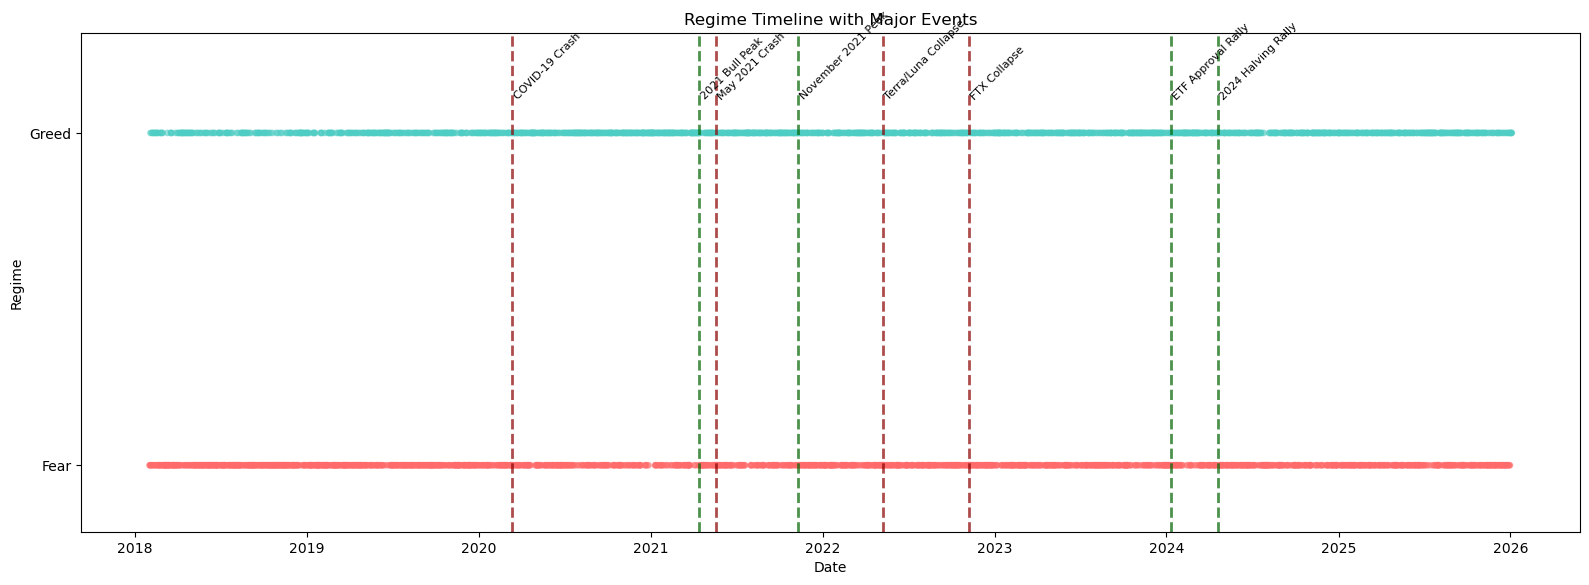

In [ ]:
# plot BTC price with regime background colors
fig, ax = plt.subplots(figsize=(18, 7))

df_plot = df.dropna(subset=['cluster'])

# plot BTC price
ax.plot(df_plot['Date'], df_plot['BTC'], color='black', linewidth=1.5, label='BTC Price', zorder=3)
ax.set_yscale('log')

# shade background by regime
prev_date = None
prev_cluster = None
for _, row in df_plot.iterrows():
    if prev_date is not None and prev_cluster is not None:
        color = '#FFE5E5' if prev_cluster == 0 else '#E5F5F5'  # light red for fear, light teal for greed
        ax.axvspan(prev_date, row['Date'], alpha=0.3, color=color, zorder=1)
    prev_date = row['Date']
    prev_cluster = row['cluster']

# mark events with vertical lines
for _, e in df_events.iterrows():
    if e['date'] >= df_plot['Date'].min() and e['date'] <= df_plot['Date'].max():
        color = 'red' if 'crash' in e['name'].lower() or 'collapse' in e['name'].lower() else 'green'
        linestyle = '--' if 'crash' in e['name'].lower() or 'collapse' in e['name'].lower() else '-.'
        ax.axvline(x=e['date'], color=color, linestyle=linestyle, alpha=0.8, linewidth=2, zorder=2)

# add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFE5E5', alpha=0.3, label='Fear Regime'),
    Patch(facecolor='#E5F5F5', alpha=0.3, label='Greed Regime'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Crash Events'),
    plt.Line2D([0], [0], color='green', linestyle='-.', linewidth=2, label='Rally Events')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_ylabel('BTC Price (USD, log scale)')
ax.set_xlabel('Date')
ax.set_title('Market Regimes vs Major Events')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Red background = Fear regime, Light blue = Greed regime")

## Check each event

In [5]:
# check what regime each event landed in
print("Event date checks:\n")

correct = 0
total = 0

for _, e in df_events.iterrows():
    event_row = df[df['Date'] == e['date']]
    
    if len(event_row) > 0 and not pd.isna(event_row['cluster'].values[0]):
        actual = int(event_row['cluster'].values[0])
        actual_name = 'fear' if actual == 0 else 'greed'
        match = '✓' if actual_name == e['should_be'] else '✗'
        
        if actual_name == e['should_be']:
            correct += 1
        total += 1
        
        print(f"{match} {e['date'].strftime('%Y-%m-%d')} {e['name']:<25} -> {actual_name:<6} (expected {e['should_be']})")
    else:
        print(f"? {e['date'].strftime('%Y-%m-%d')} {e['name']:<25} -> no data")

if total > 0:
    print(f"\nMatched: {correct}/{total} ({correct/total*100:.0f}%)")

Event date checks:

✓ 2020-03-12 COVID-19 Crash            -> fear   (expected fear)
✓ 2021-04-14 2021 Bull Peak            -> greed  (expected greed)
✓ 2021-05-19 May 2021 Crash            -> fear   (expected fear)
✗ 2021-11-10 November 2021 Peak        -> fear   (expected greed)
✓ 2022-05-09 Terra/Luna Collapse       -> fear   (expected fear)
✓ 2022-11-08 FTX Collapse              -> fear   (expected fear)
✓ 2024-01-11 ETF Approval Rally        -> greed  (expected greed)
✓ 2024-04-20 2024 Halving Rally        -> greed  (expected greed)

Matched: 7/8 (88%)
